In [3]:
import torch

import clip
from utils.vit_cam import interpret_vit

import cv2
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

## 0. Utils函数

In [4]:
# 用于读取图片
# 1. 读取图片：直接使用opencv获取的。
# 2. 还需要考虑图片的resize：长边固定为1024
# 3. SAM和SAM2都是使用opencv读取的图片进行inference; FastSAM使用路径提供图片即可。

def getImage_opencv(img_path, resized_width = 1024, color_space="rgb"):
    img = cv2.imread(img_path)
    if color_space == "rgb":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width = img.shape[:2]
    resized_height = resized_width * height/width
    img = cv2.resize(img, (int(resized_width), int(resized_height)))
    return img

def getImage_pillow(img_path, resized_width = 1024):
    img = Image.open(img_path)
    img = img.convert("RGB")
    
    width, height = img.size
    resized_height = resized_width * height/width
    img = img.resize((int(resized_width), int(resized_height)))
    return img

def opencv_to_pillow(img):
    img = Image.fromarray(img)
    return img

In [5]:
def show_cam_on_image(img, mask, neg_saliency=False):
    # mask = (mask - mask.min()) / (mask.max() - mask.min())  # 归一化
    mask = 1 - mask  # 反转显著性值
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam
    
def gradcam(preprocess_img, text_feature, img_encoder, width=224, height=224, attn_layer=-1, verbose=False):
    # 1. 获取图片特征
    img_encoder.eval()
    image = preprocess_img.type(clip_model.dtype)
    img_feature = img_encoder(image)

    if verbose:
        print(f"text feature:{text_feature.shape}   image feature:{img_feature.shape}")

    # 2. 特征归一化
    image_features_norm = img_feature.norm(dim=-1, keepdim=True)
    image_features_new = img_feature / image_features_norm
    target_features_norm = text_feature.norm(dim=-1, keepdim=True)
    target_features_new = text_feature / target_features_norm

    # 3. 计算特征相似度
    similarity = image_features_new[0].dot(target_features_new[0])

    # 4. 梯度回传
    img_encoder.zero_grad()
    similarity.backward(retain_graph=True) # 计算梯度

    # 5. 获取模型中的每个残差块
    # 5.1 获取每一个注意力块ResidualAttentionBlock(): ViT-L-14(24个注意力块) & ViT-B-32(12个注意力块)
    image_attn_blocks = list(dict(img_encoder.transformer.resblocks.named_children()).values())
    # 5.2 获取token数量(token是指模型中，注意力机制处理的序列长度或标记)
    # 注意力机制中的 token 数量是指输入序列中的元素数量。
    # 对于图像处理任务，token通常是图像被分割成的 patch 或位置嵌入。
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]

    # 6. 获取注意力层前向传播的权重和反向传播的梯度
    # 6.1 获取最后一个注意力层的权值
    last_attn = image_attn_blocks[attn_layer].attn_probs.detach()
    last_attn = last_attn.reshape(-1, last_attn.shape[-1], last_attn.shape[-1])
    # 6.2 获取最后一个注意力层的梯度
    last_grad = image_attn_blocks[attn_layer].attn_grad.detach()
    last_grad = last_grad.reshape(-1, last_grad.shape[-1], last_grad.shape[-1])
    # vit-B-32: last_attn==>torch.Size([16, 257, 257]) ==> 1+16*16 = 257, 第0个token是CLS; 第0维的含义：注意力头的数量
    # vit-L-14: last_attn==>torch.Size([12, 50, 50]) ==> 1+7*7 = 50, 第0个token是CLS; 第0维的含义：注意力头的数量

    # 7. 计算cam
    # 计算最后一个部分的gradcam
    cam = last_grad * last_attn
    cam = cam.clamp(min=0).mean(dim=0) 
    # 去除CLS token
    image_relevance = cam[0, 1:] # image_relevance ==> torch.Size([49])
    # 1. cam[0,...] 选取的是注意力矩阵的第一行。
    # 这对应于CLS Token对其他token的注意力权重。
    # 在 ViT 模型中，CLS token 用于聚合整个图像的信息，所以它对其他 token 的注意力可以反映各个图像区域的重要性。
    # 2. cam[0,1:] 选取的是注意力矩阵的第一行。
    # 只保留索引 1 到 49，这些是 CLS token 对实际图像 patch 的注意力权重。

    # 8. 对image_relevance进行后处理
    # 将图片reshape到一个正方形
    # image_relevance = image_relevance.reshape(1, 1, 7, 7) # vit_b-32
    image_relevance = image_relevance.reshape(1, 1, 16, 16) # vit_L-14
    # 将图片上采样到224*224
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bicubic') #bilinear
    image_relevance = image_relevance.reshape(224,224).data.cpu().numpy() # 转换为numpy数组
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min()) # 归一化显著性图

    # 9. 对图片进行后处理
    # 处理图片
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis) # 转换到0-255范围
    vis = cv2.resize(vis, (width,height))

    return vis

## 1. GradCAM

In [6]:
# 1. 定义模型
clip_model_list = {
    "RN50x64":"./weights/clip_models/clip/RN50x64.pt",
    "ViT-B-16":"./weights/clip_models/clip/ViT-B-16.pt",
    "ViT-B-32":"./weights/clip_models/clip/ViT-B-32.pt", 
    # image_encoder: 特征维度使用的是768; 层数: 11个残差注意力层; 起始卷积层核大小为14; 最后输出特征维度为512
    # text_encoder: 特征维度使用的是512; 模型的结构是一样的，但是特征维度不一样; 最后输出特征维度为768
    "ViT-L-14":"./weights/clip_models/clip/ViT-L-14.pt" 
    # image_encoder: 特征维度使用的是1024; 层数: 23个残差注意力层; 起始卷积层核大小为32
    # text_encoder: 特征维度使用的是768; 模型的结构是一样的，但是特征维度不一样
}
clip_name = "ViT-L-14" # img_fea:768---text_fea:512
clip_model, preprocess = clip.load(name=clip_model_list[clip_name], device=device)
# clip的ResidualAttentionBlock
# (attn): MultiheadAttention
# (ln_1): LayerNorm
# (mlp): Sequential[(c_fc): Linear, (gelu): QuickGELU, (c_proj): Linear]
# (ln_2): LayerNorm

In [352]:
# 1. 定义图片
imgid = 14
img_path = f"./explainable data/test_{imgid}.jpg"
img_pillow = getImage_pillow(img_path = img_path, resized_width = 1024)
img_opencv = getImage_opencv(img_path = img_path, resized_width = 1024, color_space="rgb")

img_pillow_resize = img_pillow.resize((224,224)) # 因此只有resize到(224,224)才能获取画面的全局。
# clip model中的图像处理方法：
# Compose(
#     Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
#     CenterCrop(size=(224, 224))
#     <function _convert_image_to_rgb at 0x000001F549A42CB0>
#     ToTensor()
#     Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
# )

# 2. 定义关键字
keywords = ["onsite worker", "safety cone", "excavator", 
            "construction material: rebar", "construction tool: safety cone",
            "tool: shovel","construction tool: portable ladder",
            "circular saw","compact car","safety cone",
            "helmet", "hardhat","construction tool: barricade"
           ]
keyword = keywords[0]

In [353]:
# 1. 文本预处理
text_embedding = clip.tokenize(texts=keyword, context_length=77).to(device) # tokenizer应该是一样的
# 2. 图片预处理
preprocessed_img = preprocess(img_pillow_resize).unsqueeze(0).to(device) # 预处理方法是一致的
# 3. 获取文本特征
text_feature = clip_model.encode_text(text_embedding) # 特征维度不一样

In [354]:
vis = gradcam(
    preprocessed_img, 
    text_feature, 
    img_encoder = clip_model.visual, 
    width=img_pillow.size[0], 
    height=img_pillow.size[1], 
    attn_layer=-1,
    verbose=True
)

text feature:torch.Size([1, 768])   image feature:torch.Size([1, 768])


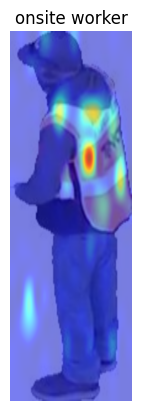

In [355]:
plt.imshow(vis)
plt.axis("off")
plt.title(f"{keyword}")
plt.show()
target = Image.fromarray(vis)
target.save(f"./explainable data/results/{imgid}_{keyword}.jpg")

## 2. 原始代码复刻

In [305]:
print("model name: ",clip_name)
img_encoder = clip_model.visual
img_encoder.eval()
image = preprocessed_img.type(clip_model.dtype)
img_feature = img_encoder(image)

print(f"text feature:{text_feature.shape}   image feature:{img_feature.shape}")

model name:  ViT-L-14
text feature:torch.Size([1, 768])   image feature:torch.Size([1, 768])


In [306]:
# 将特征进行归一化处理
image_features_norm = img_feature.norm(dim=-1, keepdim=True)
image_features_new = img_feature / image_features_norm
target_features_norm = text_feature.norm(dim=-1, keepdim=True)
target_features_new = text_feature / target_features_norm
# 计算特之间的相似性
similarity = image_features_new[0].dot(target_features_new[0])

In [307]:
img_encoder.zero_grad()
similarity.backward(retain_graph=True) # 计算梯度

In [308]:
# 1.1 获取每一个注意力块ResidualAttentionBlock(): ViT-L-14(24个注意力块) & ViT-B-32(12个注意力块)
image_attn_blocks = list(dict(img_encoder.transformer.resblocks.named_children()).values())

# 1.2 获取token数量(token是指模型中，注意力机制处理的序列长度或标记)
# 注意力机制中的 token 数量是指输入序列中的元素数量。
# 对于图像处理任务，token通常是图像被分割成的 patch 或位置嵌入。
num_tokens = image_attn_blocks[0].attn_probs.shape[-1]

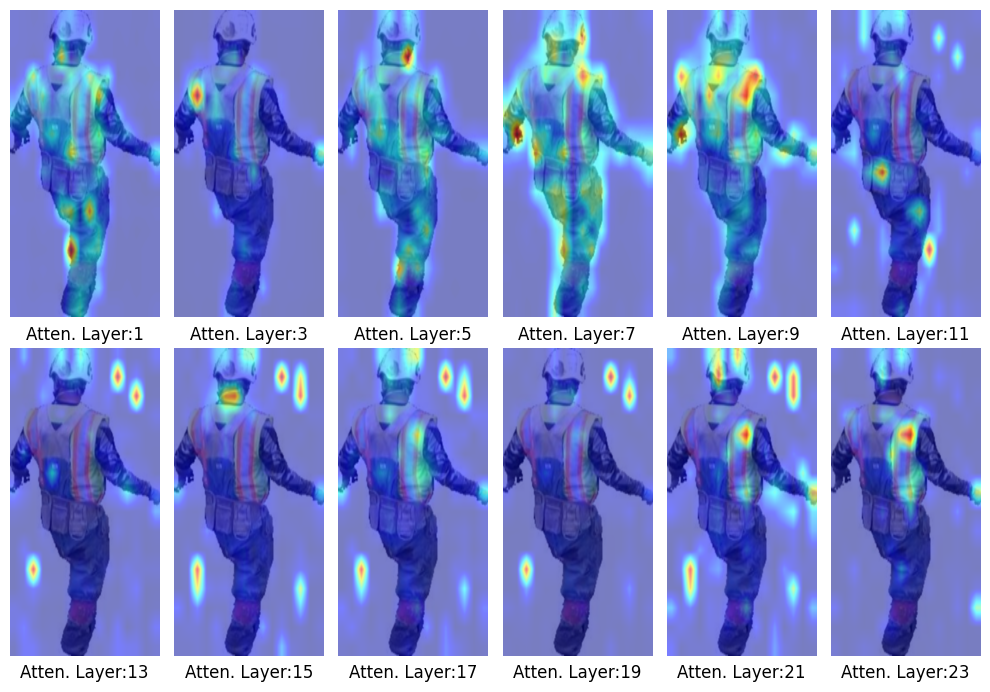

In [326]:
fig, axes = plt.subplots(2, 6, figsize=(10, 7))
axes = axes.flatten()
current_plot = 0

for i in range(len(image_attn_blocks)):
    if i % 2 == 0:
        continue

    image = preprocessed_img.type(clip_model.dtype)
    
    # 2.1 获取最后一个注意力层的权值
    last_attn = image_attn_blocks[i].attn_probs.detach()
    last_attn = last_attn.reshape(-1, last_attn.shape[-1], last_attn.shape[-1])
    # 2.2 获取最后一个注意力层的梯度
    last_grad = image_attn_blocks[i].attn_grad.detach()
    last_grad = last_grad.reshape(-1, last_grad.shape[-1], last_grad.shape[-1])

    # 计算最后一个部分的gradcam
    cam = last_grad * last_attn
    cam = cam.clamp(min=0).mean(dim=0) 
    # 去除CLS token
    image_relevance = cam[0, 1:] # image_relevance ==> torch.Size([49])

    # image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = image_relevance.reshape(1, 1, 16, 16)
    # 将图片上采样到224*224
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear') 
    image_relevance = image_relevance.reshape(224,224).data.cpu().numpy() # 转换为numpy数组
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min()) # 归一化显著性图

    # 处理图片
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis) # 转换到0-255范围
    vis = cv2.resize(vis, (1024,2110))

    axes[current_plot].imshow(vis)
    axes[current_plot].set_title(f"Atten. Layer:{i}", loc='center', y=-0.1)
    axes[current_plot].axis('off')
    current_plot+=1

plt.tight_layout()
plt.show()

In [92]:
len(imag)

24

In [80]:
# 2.1 获取最后一个注意力层的权值
last_attn = image_attn_blocks[-1].attn_probs.detach()
last_attn = last_attn.reshape(-1, last_attn.shape[-1], last_attn.shape[-1])
# 2.2 获取最后一个注意力层的梯度
last_grad = image_attn_blocks[-1].attn_grad.detach()
last_grad = last_grad.reshape(-1, last_grad.shape[-1], last_grad.shape[-1])
# vit-B-32: last_attn==>torch.Size([16, 257, 257]) ==> 1+16*16 = 257, 第0个token是CLS; 第0维的含义：注意力头的数量
# vit-L-14: last_attn==>torch.Size([12, 50, 50]) ==> 1+7*7 = 50, 第0个token是CLS; 第0维的含义：注意力头的数量

对于一个标准的输入图像（通常是 224×224 像素），ViT-L/14 会将图像分割成 14×14 像素的 patch，所以：

+ 图像大小是 224×224 像素
+ Patch 大小是 14×14 像素
+ 水平方向有 224÷14 = 16 个 patch
+ 垂直方向有 224÷14 = 16 个 patch
+ 总的 patch 数量是 16×16 = 256 个

此外，ViT 模型通常会添加一个特殊的分类 token（CLS token）放在序列的开始位置，用于进行最终的特征表示   
因此，ViT-L/14 的总 token 数量是：256 + 1 = 257 个 token。

In [81]:
last_grad.shape

torch.Size([16, 257, 257])

In [82]:
# 计算最后一个部分的gradcam
cam = last_grad * last_attn
cam = cam.clamp(min=0).mean(dim=0) 
# 去除CLS token
image_relevance = cam[0, 1:] # image_relevance ==> torch.Size([49])
# 1. cam[0,...] 选取的是注意力矩阵的第一行。
# 这对应于CLS Token对其他token的注意力权重。
# 在 ViT 模型中，CLS token 用于聚合整个图像的信息，所以它对其他 token 的注意力可以反映各个图像区域的重要性。
# 2. cam[0,1:] 选取的是注意力矩阵的第一行。
# 只保留索引 1 到 49，这些是 CLS token 对实际图像 patch 的注意力权重。

In [83]:
image_relevance.shape

torch.Size([256])

In [84]:
# 将图片reshape到一个正方形
# image_relevance = image_relevance.reshape(1, 1, 7, 7)
image_relevance = image_relevance.reshape(1, 1, 16, 16)
# 将图片上采样到224*224
image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear') 
image_relevance = image_relevance.reshape(224,224).data.cpu().numpy() # 转换为numpy数组
image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min()) # 归一化显著性图

In [85]:
# 处理图片
image = image[0].permute(1, 2, 0).data.cpu().numpy()
image = (image - image.min()) / (image.max() - image.min())
# image = np.round(image * 255).astype(np.uint8) 

In [86]:
def show_cam_on_image(img, mask, neg_saliency=False):
    # mask = (mask - mask.min()) / (mask.max() - mask.min())  # 归一化
    mask = 1 - mask  # 反转显著性值
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

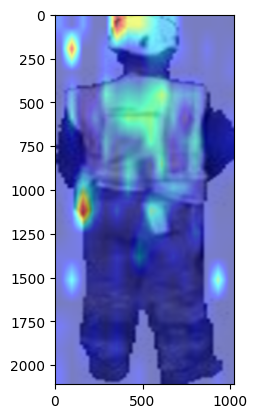

In [87]:
vis = show_cam_on_image(image, image_relevance)
vis = np.uint8(255 * vis) # 转换到0-255范围
vis = cv2.resize(vis, (1024,2110))
plt.imshow(vis)
plt.show()

In [88]:
region = img_opencv[0:250,0:200]
np.unique(region)

array([255], dtype=uint8)

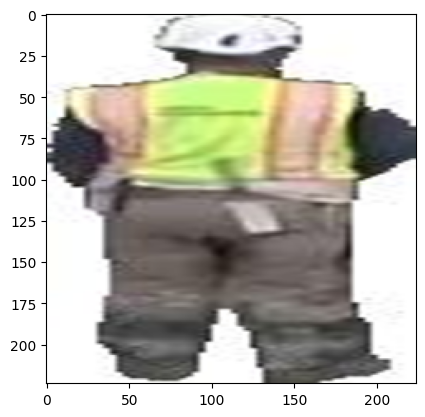

In [89]:
plt.imshow(img_pillow)
plt.show()

## 3. 原始代码测试

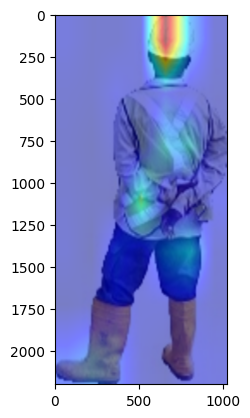

In [84]:
# The available visualization methods are: 'gradcam', 'last grad', 'all grads'
methods = {"1":"gradcam", "2":"all grads", "3":"last grad"}

vis = interpret_vit(
    image = preprocessed_img.type(clip_model.dtype),
    target_features = text_feature,  # text_feature: torch.Size([1, 512])
    img_encoder = clip_model.visual, # image_encoder: 特征维度使用的是768; 层数: 11个残差注意力层; 起始卷积层核大小为14
    device = device,
    method='gradcam',
    width = 1024,
    height = 2201,
    model_name = clip_name
)

In [19]:
cv2.imshow("hh",vis)

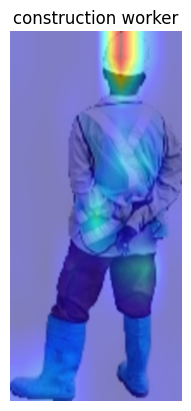

In [13]:
plt.imshow(vis)
plt.title("construction worker")
plt.axis("off")
plt.show()

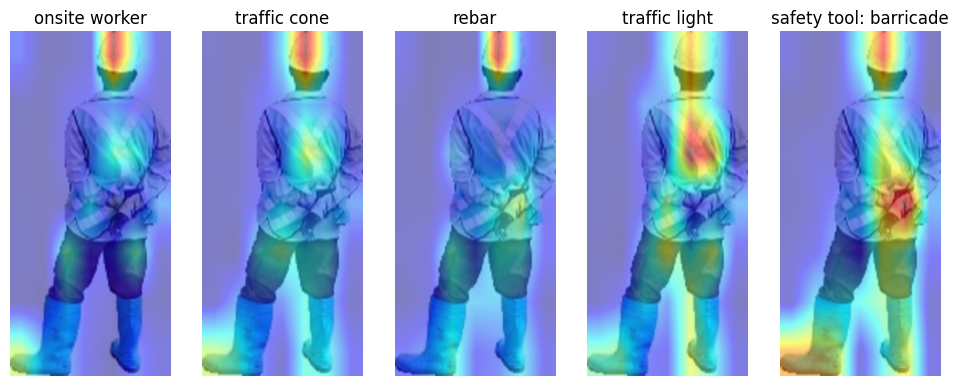

In [16]:
plt.figure(figsize=(12,8))
keywords = ["onsite worker", "traffic cone", "rebar", "traffic light", "safety tool: barricade"]
for i, kw in enumerate(keywords):
    text_embedding = clip.tokenize(texts=kw, context_length=77).to(device)
    text_feature = clip_model.encode_text(text_embedding)

    
    
    vis = interpret_vit(
        image = preprocessed_img.type(clip_model.dtype),
        target_features = text_feature, 
        img_encoder = clip_model.visual,
        device = device,
        method='last grad',
        width = 1024,
        height = 2201,
        model_name = clip_name
    )
    plt.subplot(1,5, i+1)
    plt.imshow(vis)
    plt.title(f"{kw}")
    plt.axis("off")

plt.savefig("./output.svg",format="svg")
plt.show()


In [ ]:
vis = interpret_vit(
    image = preprocessed_img.type(clip_model.dtype),
    target_features = text_feature, 
    img_encoder = clip_model.visual,
    device = device,
    method='last grad',
    width = 1024,
    height = 1857,
    model_name = clip_name
)

